# Exercise 4: K-Means Clustering

In this exercise, we will work on K-Means clustering. You will be asked to cluster the MNIST dataset using the K-Means algorithm.

MNIST is a database of handwritten digits. Each image is 28x28, grayscale, and represents a digit between 0 and 9.

Let's get started!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

## Helper functions 
These functions will help us load and visualize the data. You can simply run the cell below.

In [2]:
def display_digit(digit, label=None, training_or_inferred="training", ax=None):
    """Graphically display a 784x1 vector, representing a digit, and optionally show the corresponding label."""
    if ax is None:
        plt.figure()
        fig = plt.imshow(digit.reshape(28,28))
    else:
        fig = ax.imshow(digit.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if label is not None:
        if training_or_inferred == "training":
            title_str = "GT label: "
        else:
            title_str = "Inferred label: "
        if ax is None:
            plt.title(title_str  + str(int(label)))
        else:
            ax.set_title(title_str  + str(int(label)))

def display_centers(centers, title="Cluster centers"):
    K = len(centers)
    n_row = int(np.ceil(K / 5))

    fig, axes = plt.subplots(n_row, 5, figsize=(15, 2.5 * n_row))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < K:
            display_digit(centers[i], ax=ax)
        else:
            ax.axis('off')

# 1. Load and visualize the MNIST dataset

The MNIST database contains a total of 70,000 handwritten digits with 10 different classes, from 0 to 9. 60,000 examples are taken as training dataset and the remaining 10,000 as test set. The digits have been size-normalized and centered in a fixed-size image. 

First download MNIST from: [https://www.python-course.eu/data/mnist/mnist_train.csv]() and put this csv file in the same folder as your jupyter notebook file. (You may have already done this in a previous exercise, it is fine to reuse the same csv file.)

Each image is flattened to a vector of size $784$ with integers in the range $[0, 255]$, and the images can be reshaped to $28 \times 28$. The value of the pixels indicate the brightness of a pixel, that is, the higher number the brighter the pixel.

To make sure everything went fine, we will first load the dataset and visualize some samples from it. It might take a while to load it into memory! We will then subsample the dataset. The MNIST database is huge, and our algorithm will take very long if we want to use all the data. Therefore we will only use the first 1200 samples as our training dataset. We will also use 500 samples for validation and another 500 for test.

In [3]:
# Load the dataset
image_size = 28  # width and length
n_classes = 10  # i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size  # 28*28 = 784

# Load the data. This loads a Nx785 array, where the first column is actually the label.
full_data = np.loadtxt("mnist_train.csv", delimiter=",")

# Build the train set
n_train = 1200
n_val = 500
n_test = 500

x_train = full_data[:n_train, 1:]
y_train = full_data[:n_train, 0].astype(int)
x_val = full_data[n_train : n_train + n_val, 1:]
y_val = full_data[n_train : n_train + n_val, 0].astype(int)
x_test = full_data[n_train + n_val : n_train + n_val + n_test, 1:]
y_test = full_data[n_train + n_val : n_train + n_val + n_test, 0].astype(int)

print(f"Shape of training data={x_train.shape}, shape of label={y_train.shape}")
print(f"Shape of validation data={x_val.shape}, shape of label={y_val.shape}")
print(f"Shape of test data={x_test.shape}, shape of label={y_test.shape}")

Shape of training data=(1200, 784), shape of label=(1200,)
Shape of validation data=(500, 784), shape of label=(500,)
Shape of test data=(500, 784), shape of label=(500,)


### Image visualization

We can use the helper function `display_digit()` to display the image of each data sample.

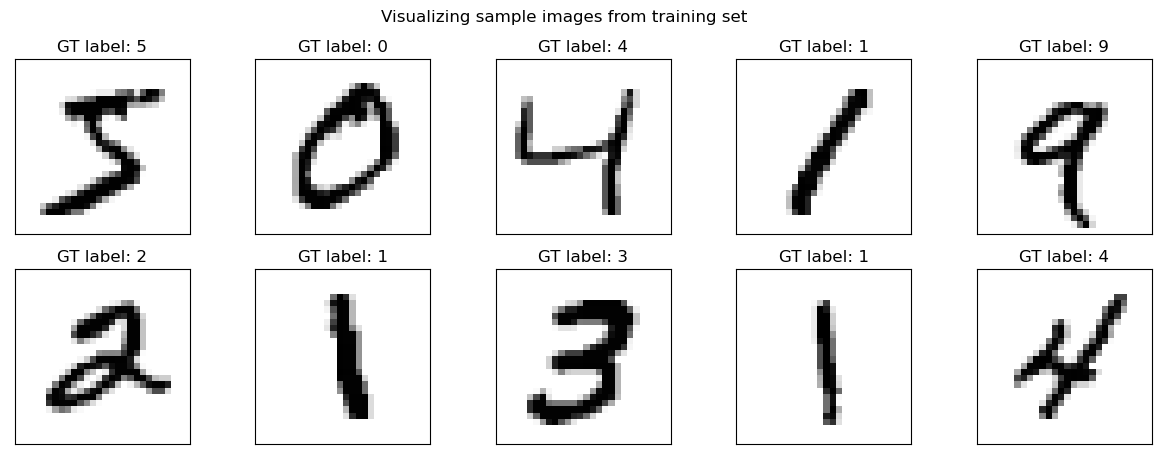

In [4]:
# We visualize the first 10 samples from the training set, with their label.
fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.suptitle("Visualizing sample images from training set")
for i, ax in enumerate(axes.flat):
    display_digit(x_train[i], y_train[i], "training", ax)

# 2. K-Means clustering

In this section we will learn how to implement the K-Means algorithm. The procedure is quite simple:

1. Initialize the cluster centers (randomly in our case, but there are more clever methods for initialization out there!)
2. Loop until the cluster centers don't move anymore or we reach the max number of iterations:
    1. Compute the distance of each point to the clusters and assign it to the closest cluster.
    2. Update the cluster centers as the mean of the data points assigned to it.

## 2.1 Cluster initialization

First we will initialize K cluster centers randomly. Fill in the function to pick K points randomly from the given dataset as initial cluster centers and return them.

*Hint:* you can randomly choose the index of the points, and then use these indices to select the data points. Look into `np.random.permutation`.

In [5]:
def init_centers(data, K):
    """
    Randomly pick K data points from the data as initial cluster centers.
    
    Arguments: 
        data: array of shape (NxD) where N is the number of data points and D is the number of features (:=pixels).
        K: int, the number of clusters.
    Returns:
        centers: array of shape (KxD) of initial cluster centers
    """
    print(data.shape)
    data_shuffled = np.random.permutation(data)

    return data_shuffled[:K]

Let's use this function to first initialize 10 cluster centers and then visualize them.

(1200, 784)


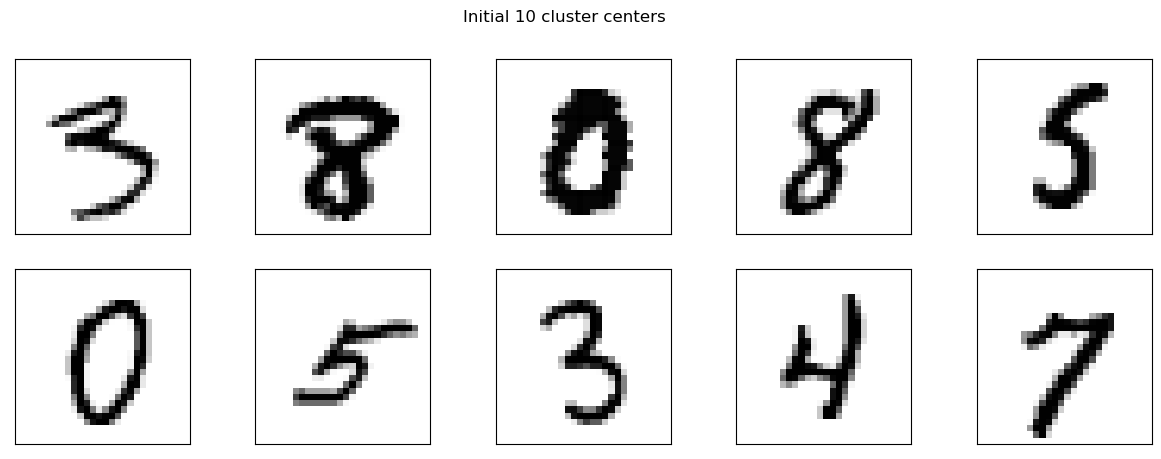

In [6]:
# Define the number of clusters, initialize their centers and display them.
K = 10
centers = init_centers(x_train, K)
display_centers(centers, "Initial {} cluster centers".format(K))

## 2.2 Cluster assignment
Now let us implement some essential components of the k-means algorithm: 
* a function to compute the distance of each data point to all cluster centers `compute_distance()`
* and a function to assign each data point to the closest cluster center `find_closest_cluster()`.

The L2 (or Euclidean) distance between a data point $\mathbf{x}_i$ and cluster center $\mu_k$ is
$$ d_{ik} = \sqrt{\sum_{d=1}^D \left(\mathbf{x}_i^{(d)} - \mu_k^{(d)}\right)^2 }, $$
where $\cdot^{(d)}$ means the *d*th coordinate.

In [7]:
def compute_distance(data, centers):
    """
    Compute the euclidean distance between each datapoint and each center.
    
    Arguments:    
        data: array of shape (N, D) where N is the number of data points, D is the number of features (:=pixels).
        centers: array of shape (K, D), centers of the K clusters.
    Returns:
        distances: array of shape (N, K) with the distances between the N points and the K clusters.
    """
    N = data.shape[0]
    K = centers.shape[0]

    distances = np.zeros((N, K))

    for k in range(K):
        distances[:, k] = np.sqrt(np.sum((data - centers[k]) ** 2, axis=1))
    return distances

In [8]:
def find_closest_cluster(distances):
    """
    Assign datapoints to the closest clusters.
    
    Arguments:
        distances: array of shape (N, K), the distance of each data point to each cluster center.
    Returns:
        cluster_assignments: array of shape (N,), cluster assignment of each datapoint, which are an integer between 0 and K-1.
    """

    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments

Let's check the results after building clusters based on the initial cluster centers.

In [9]:
distances = compute_distance(x_train, centers)
cluster_assignments = find_closest_cluster(distances)

# The number of clusters should be the same as the number of centers, which is 10 here
print('The number of clusters are:', len(centers))
for i in np.arange(n_classes):
    print(f'The number of data points assigned to the cluster {i+1} is {np.sum(cluster_assignments == i)}.')

assert distances.shape == (x_train.shape[0], centers.shape[0]), "distances is not of the correct shape!"
assert cluster_assignments.shape == (x_train.shape[0],), "cluster_assignments is not of the correct shape!"

The number of clusters are: 10
The number of data points assigned to the cluster 1 is 34.
The number of data points assigned to the cluster 2 is 13.
The number of data points assigned to the cluster 3 is 48.
The number of data points assigned to the cluster 4 is 109.
The number of data points assigned to the cluster 5 is 163.
The number of data points assigned to the cluster 6 is 78.
The number of data points assigned to the cluster 7 is 240.
The number of data points assigned to the cluster 8 is 114.
The number of data points assigned to the cluster 9 is 230.
The number of data points assigned to the cluster 10 is 171.


We can also take a look at the different clusters after initialization.

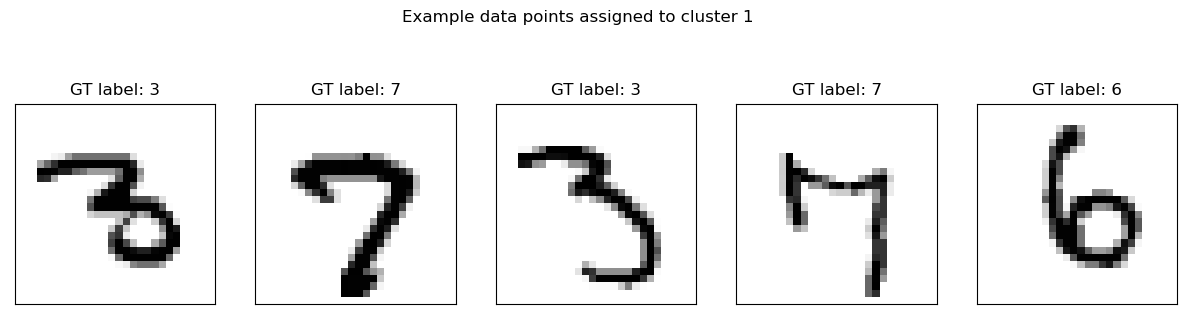

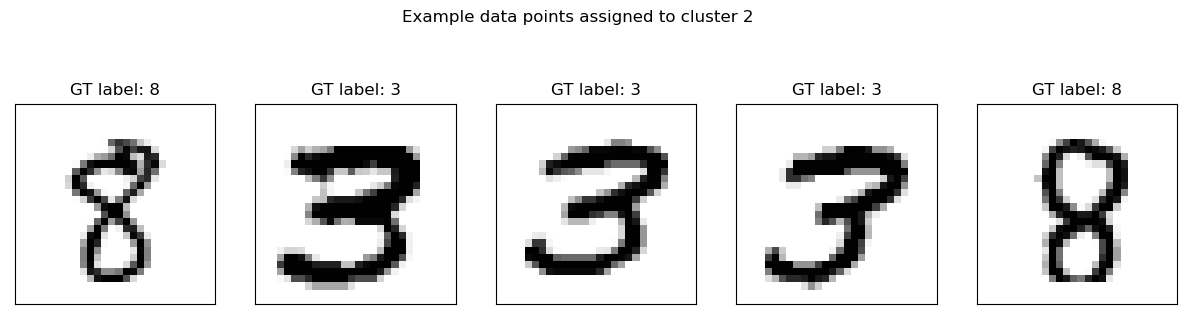

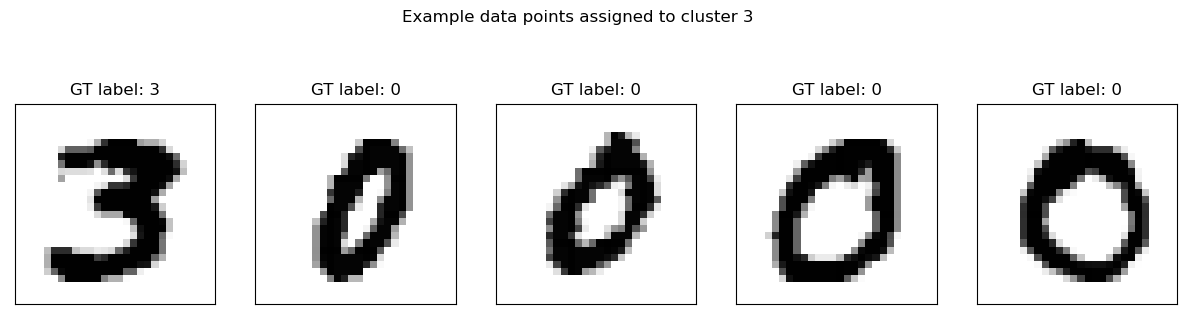

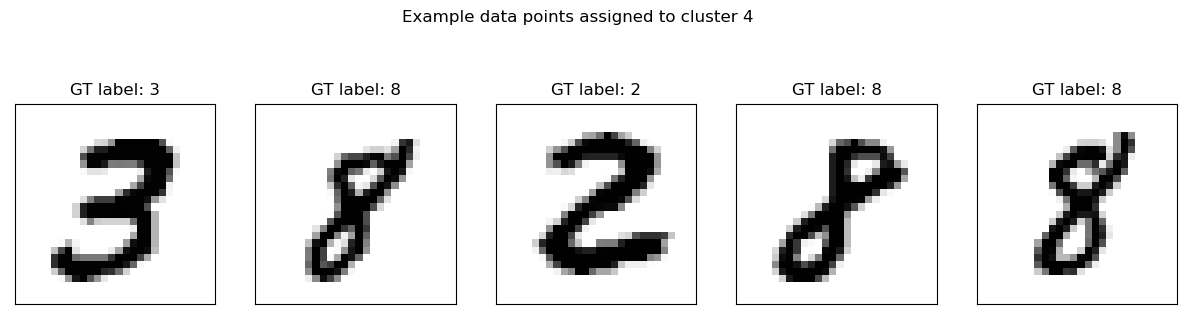

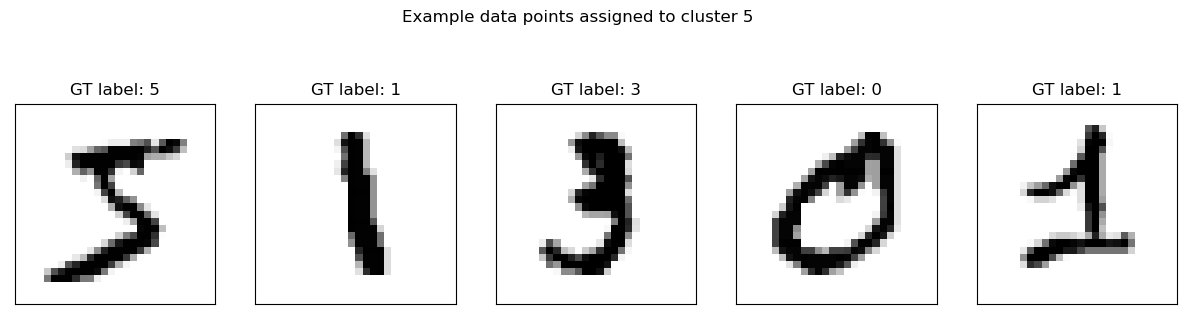

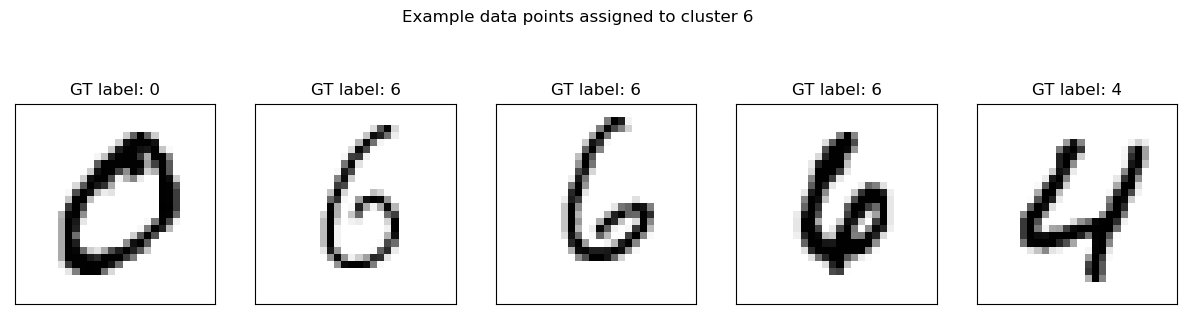

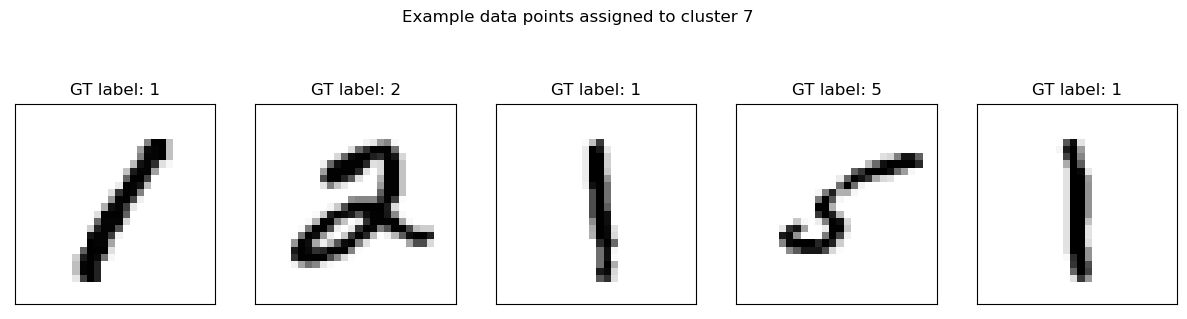

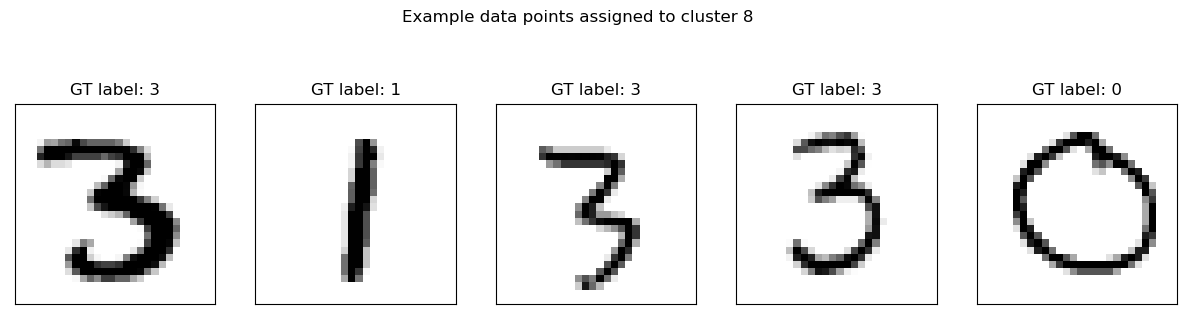

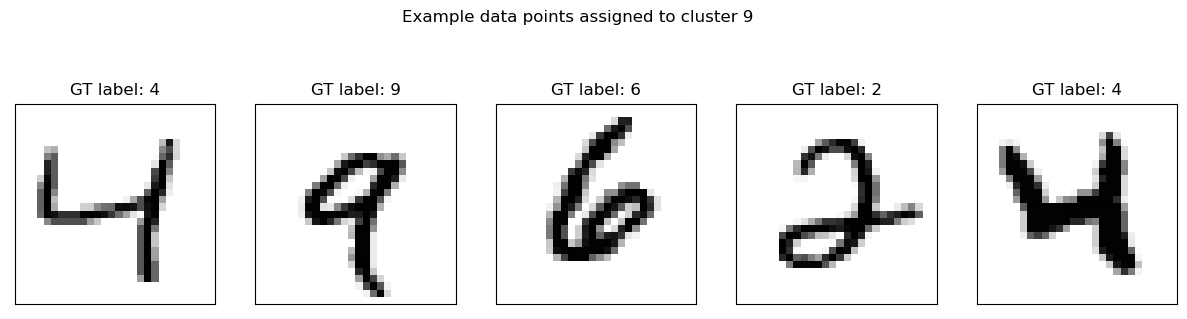

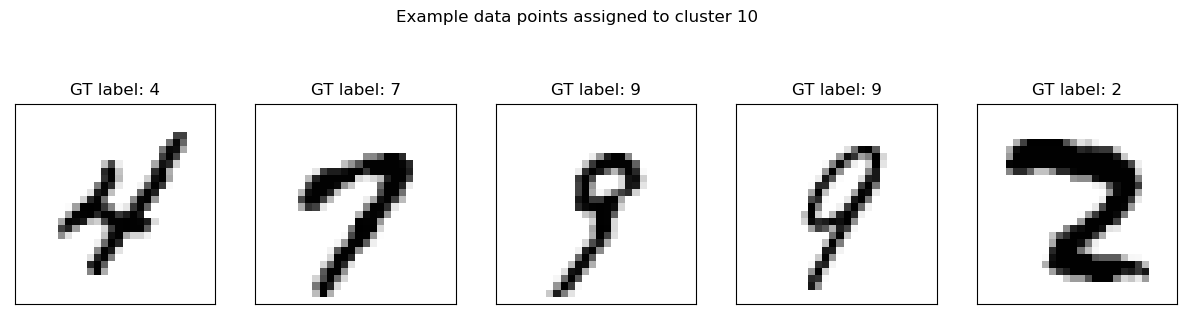

In [10]:
# We visualize 5 images in each cluster
for k in range(K):
    fig, axes = plt.subplots(1, 5, figsize=(15,4))
    fig.suptitle("Example data points assigned to cluster {}".format(k+1))
    cluster_points = x_train[cluster_assignments == k]
    cluster_points_label = y_train[cluster_assignments == k]
    for col in range(5):
        display_digit(cluster_points[col], cluster_points_label[col], "training", axes[col])

## 2.3 Cluster update

And now we need to update the cluster centers to be the mean of the data points assigned to each cluster.

The center of cluster $k$ is given by
$$ \mu_k = \frac1{N_k} \sum_{i\in C_k} \mathbf{x}_i, $$
where $C_k$ is the set of points assigned to cluster $k$, and $\left\lvert C_k \right\rvert = N_k$ is the number of such points.

In [11]:
def compute_centers(data, cluster_assignments, K):
    """
    Compute the center of each cluster based on the assigned points.

    Arguments: 
        data: data array of shape (N,D), where N is the number of samples, D is number of features
        cluster_assignments: the assigned cluster of each data sample as returned by find_closest_cluster(), shape is (N,)
        K: the number of clusters
    Returns:
        centers: the new centers of each cluster, shape is (K,D) where K is the number of clusters, D the number of features
    """

    centers = np.zeros((K, data.shape[1]))

    for k in range(K):
        cluster_data = data[cluster_assignments == k]
        centers[k] = np.sum(cluster_data, axis=0)/cluster_data.shape[0]

    return centers

In [12]:
# New centers after assigning the points to the previous centers
new_centers = compute_centers(x_train, cluster_assignments, K)

assert new_centers.shape == (K, x_train.shape[1]), "new_centers have wrong shape!"

What does the new centers look like? Let's visualize them.

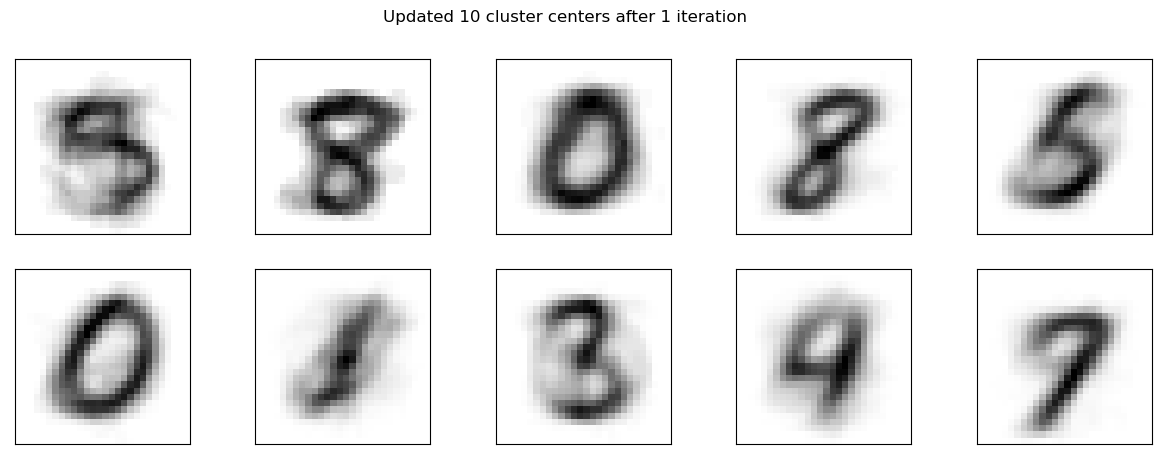

In [13]:
display_centers(new_centers, "Updated {} cluster centers after 1 iteration".format(K))

**Q.** The visualization of the new cluster centers should appear as blurry numbers, some worse than others, while the original cluster centers were clear handwritten digits. Can you explain why?

**A. Because different hand writings are not the same, and this is the mean of them**

## 2.4 Full K-Means

K-Means is an iterative algorithm that consists of two main steps after the center initialization:
1. assigning each point $\mathbf{x}_i$ to the nearest center $\mu_k$
2. updating each center $\mu_k$ given the points assigned to it

We iterate between these two steps until we converge or reach a defined maximum number of iterations. You can say that the algorithm has converged when the cluster centers do not move anymore. Fill in the function below to apply the full of K-Means.

In [14]:
def k_means(data, K, max_iter):
    """
    Main function that combines all the former functions together to build the K-means algorithm.
    
    Arguments: 
        data: array of shape (N, D) where N is the number of data samples, D is number of features.
        K: int, the number of clusters.
        max_iter: int, the maximum number of iterations
    Returns:
        centers: array of shape (K, D), the final cluster centers.
        cluster_assignments: array of shape (N,) final cluster assignment for each data point.
    """
    # Initialize the centers
    centers = init_centers(data, K)

    # Loop over the iterations
    for i in range(max_iter):
        if ((i+1) % 10 == 0):
            print(f"Iteration {i+1}/{max_iter}...")
        old_centers = centers.copy()  # keep in memory the centers of the previous iteration

        distances = compute_distance(data, centers)
        closest_clusters = find_closest_cluster(distances)
        centers = compute_centers(data, closest_clusters, K)

        # End of the algorithm if the centers have not moved (hint: use old_centers and look into np.all)
        if np.all(old_centers == centers):
            print(f"K-Means has converged after {i+1} iterations!")
            break
    
    # Compute the final cluster assignments
    cluster_assignments = find_closest_cluster(distances)
    
    return centers, cluster_assignments

In [15]:
# Let's try it on our training data
K = 10
max_iter = 1000
final_centers, cluster_assignments = k_means(x_train, K, max_iter)

(1200, 784)
Iteration 10/1000...
Iteration 20/1000...
K-Means has converged after 23 iterations!


Again, let's visualize the final clusters.

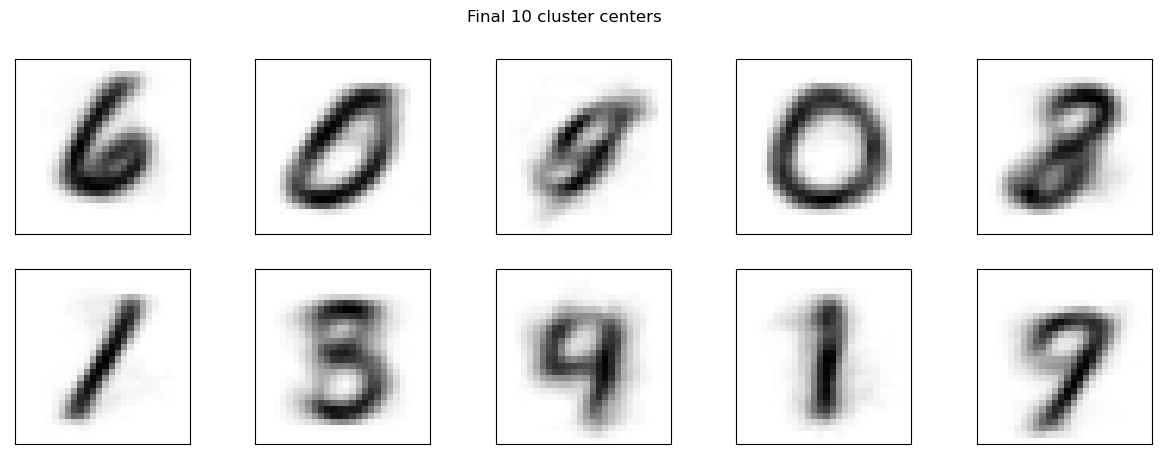

In [16]:
display_centers(final_centers, "Final {} cluster centers".format(K))

# 3. Testing K-Means

Each data point now has a cluster assignment in $\{0,..,9\}$. However, these numbers do not really reflect the label of the cluster (because they are shuffled). For example an image may belong to the 0th cluster, but this does not mean the image depicts 0. But we have access to the true label of each data point in `y_train`. Let us now make use of these.

If we want to assign the true label to each cluster after K-Means, we can do so via voting. We have now assigned to each cluster some data samples. The label of the cluster will be assigned as the most common label among these data samples (the mode). Each data point within the cluster will take the label of the cluster. (This is quite similar to the voting system of $k$-NN, except we consider the cluster here instead of the neighbors.)

**Note:** K-Means is used for clustering, which is an unsupervised method. That means it does not use data labels and if you look at your implementation of K-Means, you should see that it only depended on the data points in `x_train`! We make here use of the true label simply to verify the results of our clustering and attribute pseudo-labels to our cluster.

In [17]:
def assign_labels_to_centers(centers, cluster_assignments, true_labels):
    """
    Use voting to attribute a label to each cluster center.

    Arguments: 
        centers: array of shape (K, D), cluster centers
        cluster_assignments: array of shape (N,), cluster assignment for each data point.
        true_labels: array of shape (N,), true labels of data
    Returns: 
        cluster_center_label: array of shape (K,), the labels of the cluster centers
    """


    
    return cluster_center_label

def predict_with_centers(data, centers, cluster_center_label):
    """
    Predict the label for data, given the cluster center and their labels.
    To do this, it first assign points in data to their closest cluster, then use the label
    of that cluster as prediction.

    Arguments: 
        data: array of shape (N, D)
        centers: array of shape (K, D), cluster centers
        cluster_center_label: array of shape (K,), the labels of the cluster centers
    Returns: 
        new_labels: array of shape (N,), the labels assigned to each data point after clustering, via k-means.
    """
    ### WRITE YOUR CODE HERE
    
    return new_labels

After assigning labels to our data points, we can check for accuracy as the percent of correct labels.

In [18]:
def accuracy_fn(pred_labels, gt_labels):
    ### WRITE YOUR CODE HERE
    return ...

Let's run and test!

In [19]:
K = 10
max_iter = 1000
final_centers, cluster_assignments = k_means(x_train, K, max_iter)
cluster_center_label = assign_labels_to_centers(final_centers, cluster_assignments, y_train)
pred_labels = predict_with_centers(x_train, final_centers, cluster_center_label)
print(f"Accuracy on the train set is {accuracy_fn(pred_labels, y_train):.1f}%.")

# Let's check results on the validation set as well!
pred_labels_val = predict_with_centers(x_val, final_centers, cluster_center_label)
print(f"Accuracy on the valid set is {accuracy_fn(pred_labels_val, y_val):.1f}%.")

(1200, 784)
Iteration 10/1000...
Iteration 20/1000...
K-Means has converged after 27 iterations!


NameError: name 'cluster_center_label' is not defined

*After we choose a value for K based on the performance on the validation set*, we can try to see how this label assignment to clusters perform on unseen data. For this, we look at the accuracy on the held out test set.

In [ ]:
pred_labels_test = predict_with_centers(x_test, final_centers, cluster_center_label)
print(f"Accuracy on the test set is {accuracy_fn(pred_labels_test, y_test):.1f}%.")

Visualize some data points with their predicted labels.

In [ ]:
# Randomly select 10 points in the training set
rand_idx = np.random.permutation(x_train.shape[0])[:10]
samples = x_train[rand_idx]
pred_y = pred_labels[rand_idx]

fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.suptitle("Predictions".format(K))
for i, ax in enumerate(axes.flat):
    display_digit(samples[i], pred_y[i], "inferred", ax=ax)

Visualize the corresponding cluster centers and their label.

In [ ]:
n_row = int(np.ceil(K / 5))
fig, axes = plt.subplots(n_row, 5, figsize=(15, 2.5 * n_row))
fig.suptitle("Final {} cluster centers and their labels".format(K))
for i, ax in enumerate(axes.flat):
    if i < K:
        display_digit(final_centers[i], cluster_center_label[i], "inferred", ax=ax)
    else:
        ax.axis('off')

# 4. K-Means clustering for images
Now that we have a working K-Means, let's try something a bit different that you may have seen in the lectures: cluster the pixel colors in an image.

It consists in considering each pixel a 3D vector, where the coordinates are actually its RGB values, and performing clustering on them. Then, we can replace each pixel in the image by the center of the cluster it belongs to.

The resulting images will then only need to store K colors and a single integer per pixel (representing cluster assignment). This can be seen as a form of image compression.

Let's first load and visualize the image.

In [ ]:
image = np.array(Image.open("img/lenna.png"))

fig = plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Original image");


Now, we consider all pixels as points and run K-Means on them. Let's also make a function to visualize the results.

Complete the following code.

In [ ]:
def kmeans_on_image(image, K, max_iter):
    """
    Perform K-Means on the pixel of an image.

    Arguments:
        image: array of shape HxWx3, the RGB image
        K: int, the number of cluster
    Returns:
        pixel_centers: array of shape Kx3, centers of the cluster
        pixel_assignments: array of shape HxW, cluster assignment of each pixel
    """
    ### WRITE YOUR CODE HERE
    # First, reshape the data as an NxD array, with D=3.
    pixels = ...

    # Run K-Means on the pixels.
    ...

    # Reshape the pixel assignments back to the 2D image shape. 
    # Hint: pixel_assignments have a single value for each pixel, not RGB!
    pixel_assignments = ...

    return pixel_centers, pixel_assignments

def make_kmeans_image(pixel_centers, pixel_assignments):
    """
    Make an RGB image out of the clustered colors and pixel assignments.

    Arguments:
        pixel_centers: array of shape Kx3, centers of the cluster
        pixel_assignments: array of shape HxW, cluster assignment of each pixel
    Returns:
        kmeans_image: array of shape HxWx3, resulting image after K-Means.
    """
    K = pixel_centers.shape[0]
    H, W = pixel_assignments.shape
    
    ### WRITE YOUR CODE HERE
    
    return kmeans_image

In [ ]:
K = ...  # try different number of clusters
max_iter = 1000

pixel_centers, pixel_assignments = kmeans_on_image(image, K, max_iter)
kmeans_image = make_kmeans_image(pixel_centers, pixel_assignments)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Results with K={K}")
axs[0].imshow(image)
axs[0].set_title("Original image")
axs[1].imshow(kmeans_image)
axs[1].set_title("Image after K-Means");

# 5. Written questions

**Q1.** (MCQ) Consider the K-Means algorithm. Select all the correct statement(s) below. 
1. The K-Means algorithm learns the number of clusters while optimizing their position.
2. K-Means does not require labels for the training data.
3. Different cluster initializations always lead to the same final solution.
4. The data features should be of similar scale.

**A1.** 

**Q2.** (SCQ) We use K-Means with the Euclidean distance to cluster the 2D points represented by the crosses below. The initial cluster centers are the two circles. After convergence, what are the most plausible coordinates for the final cluster centers?

<img src="img/kmeans_q2.png" width=600>

* $(-0.67, -0.67)$ and $(6.4, 0.8)$
* $(1.6, -0.2)$ and $(7.33, 1)$
* $(-0.67, -0.67)$, $(5, 0.5)$ and $(7.33, 1)$
* $(1.6, -0.2)$ and $(6.4, 0.8)$

**A2.** 

**Q3.** Consider the two scenarios below, can you apply K-Means in their cases?
1. After a dancing tournament, your machine learning team has extracted the 3D poses of all dancers' moves. The pose for one "dancing move" can be represented as a vector of J*3 values that represent the 3D position of J joints (such as the elbows, knees, shoulders, etc.) of the dancer. You would like to regroup the similar dancing moves in this data.
2. Your little brother has had a lemonade stand for the past 2 months. He kept track of how much he sold, the daily weather, the number of people passing by, and the number of people that stopped at his stand. He asks you to use machine learning to predict how much he might sell on any given day assuming you know the rest of the information.

**A3.** 

**Q4.** K-Means with Euclidean distance works better on scaled data, e.g., when each dimension is normalized between 0 and 1. Why? In this exercise we haven't done any normalization. Can you see why it was not needed?

**A4.** 